# Synthea COVID-19 Module Analysis

This notebook (modifioed from https://github.com/synthetichealth/module-validation/blob/master/notebooks/Synthea%20COVID-19%20Analysis.ipynb) provides and analysis of data generated by [Synthea](https://synthetichealth.github.io/synthea/)'s COVID-19 module. Analysis is run on the CSV output from Synthea.

Code in this notebook depends on [Pandas](https://pandas.pydata.org/), [NumPy](https://numpy.org/), [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

In [2]:
%matplotlib inline

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
%load_ext autoreload

In [5]:
%autoreload 1

This jupyter notebook evolved over the creation of the Synthea COVID-19 Module. Initially, all python code was in the notebook. Eventually, this became unwieldy and code was moved into the imported file below.

In [6]:
%aimport analysis

Read in all of the data

In [7]:
conditions = pd.read_csv("../data-set/conditions.zip", compression='zip')
patients = pd.read_csv("../data-set/patients.zip", compression='zip')
observations = pd.read_csv("../data-set/observations.zip", compression='zip')
care_plans = pd.read_csv("../data-set/careplans.zip", compression='zip')
encounters = pd.read_csv("../data-set/encounters.zip", compression='zip')
devices = pd.read_csv("../data-set/devices.zip", compression='zip')
supplies = pd.read_csv("../data-set/supplies.zip", compression='zip')
procedures = pd.read_csv("../data-set/procedures.zip", compression='zip')
medications = pd.read_csv("../data-set/medications.zip", compression='zip')

Grab the IDs of patients that have been diagnosed with COVID-19

In [8]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

This grabs every patient with a negative SARS-CoV-2 test. This will include patients who tested negative up front as well as patients that tested negative after leaving the hospital

In [9]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

Grabs IDs for all patients that died in the simulation. This will be more than just COVID-19 deaths.

In [10]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

Grabs IDs for patients that have completed the care plan for isolation at home.

In [11]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

Survivors are the union of those who have completed isolation at home or have a negative SARS-CoV-2 test.

In [12]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

Grab IDs for patients with admission due to COVID-19

In [13]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

The number of inpatient survivors

In [14]:
np.intersect1d(inpatient_ids, survivor_ids).shape

(1431,)

The number of inpatient non-survivors

In [15]:
np.intersect1d(inpatient_ids, deceased_patients).shape

(361,)

In [16]:
inpatient_ids.shape

(1787,)

## Health outcomes experienced by COVID-19 patients

The following table shows different health outcomes that were experienced by COVID-19 patients during the course of the disease.

In [17]:
analysis.outcome_table(inpatient_ids, survivor_ids, deceased_patients, conditions)

,outcome,total,percent of inpatient,survivors,percent survivors,non survivors,percent non survivors
0,Sepsis,713,0.397879,356,0.248777,357,0.988920
1,Respiratory Failure,894,0.498884,540,0.377358,354,0.980609
2,ARDS,246,0.137277,4,0.002795,242,0.670360
3,Heart Failure,157,0.087612,14,0.009783,143,0.396122
4,Septic Shock,179,0.099888,0,0.000000,179,0.495845
5,Coagulopathy,134,0.074777,10,0.006988,124,0.343490
6,Acute Cardiac Injury,137,0.076451,0,0.000000,137,0.379501
7,Acute Kidney Injury,134,0.074777,1,0.000699,133,0.368421


## Lab values for COVID-19 patients

The following code presents lab values taken for COVID-19 patients. Values are separated into survivors and non survivors.

The first block of code selects lab values of interest from all observations in the simulation.

In [18]:
lab_obs = observations[(observations.CODE == '48065-7') | (observations.CODE == '26881-3') | 
                          (observations.CODE == '2276-4') | (observations.CODE == '89579-7') |
                          (observations.CODE == '2532-0') | (observations.CODE == '731-0') |
                          (observations.CODE == '14804-9')
                      ]

Select COVID-19 conditions out of all conditions in the simulation

In [19]:
covid_conditions = conditions[conditions.CODE == 840539006]

Merge the COVID-19 conditions with the patients

In [20]:
covid_patients = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')

Add an attribute to the DataFrame indicating whether this is a survivor or not.

In [21]:
covid_patients['survivor'] = covid_patients.PATIENT.isin(survivor_ids)

Reduce the columns on the DataFrame to ones needed

In [22]:
covid_patients = covid_patients[['START', 'PATIENT', 'survivor', 'CODE']]

Calculate attributes needed to support the plot. Also coerce all lab values into a numeric data type.

In [23]:
covid_patients_obs = covid_patients.merge(lab_obs, on='PATIENT')
covid_patients_obs['START'] = pd.to_datetime(covid_patients_obs.START, utc=True)
covid_patients_obs['DATE'] = pd.to_datetime(covid_patients_obs.DATE)
covid_patients_obs['lab_days'] = covid_patients_obs.DATE - covid_patients_obs.START
covid_patients_obs['days'] = np.around(covid_patients_obs.lab_days / np.timedelta64(1, 'D'))
covid_patients_obs['VALUE'] = pd.to_numeric(covid_patients_obs['VALUE'], errors='coerce')

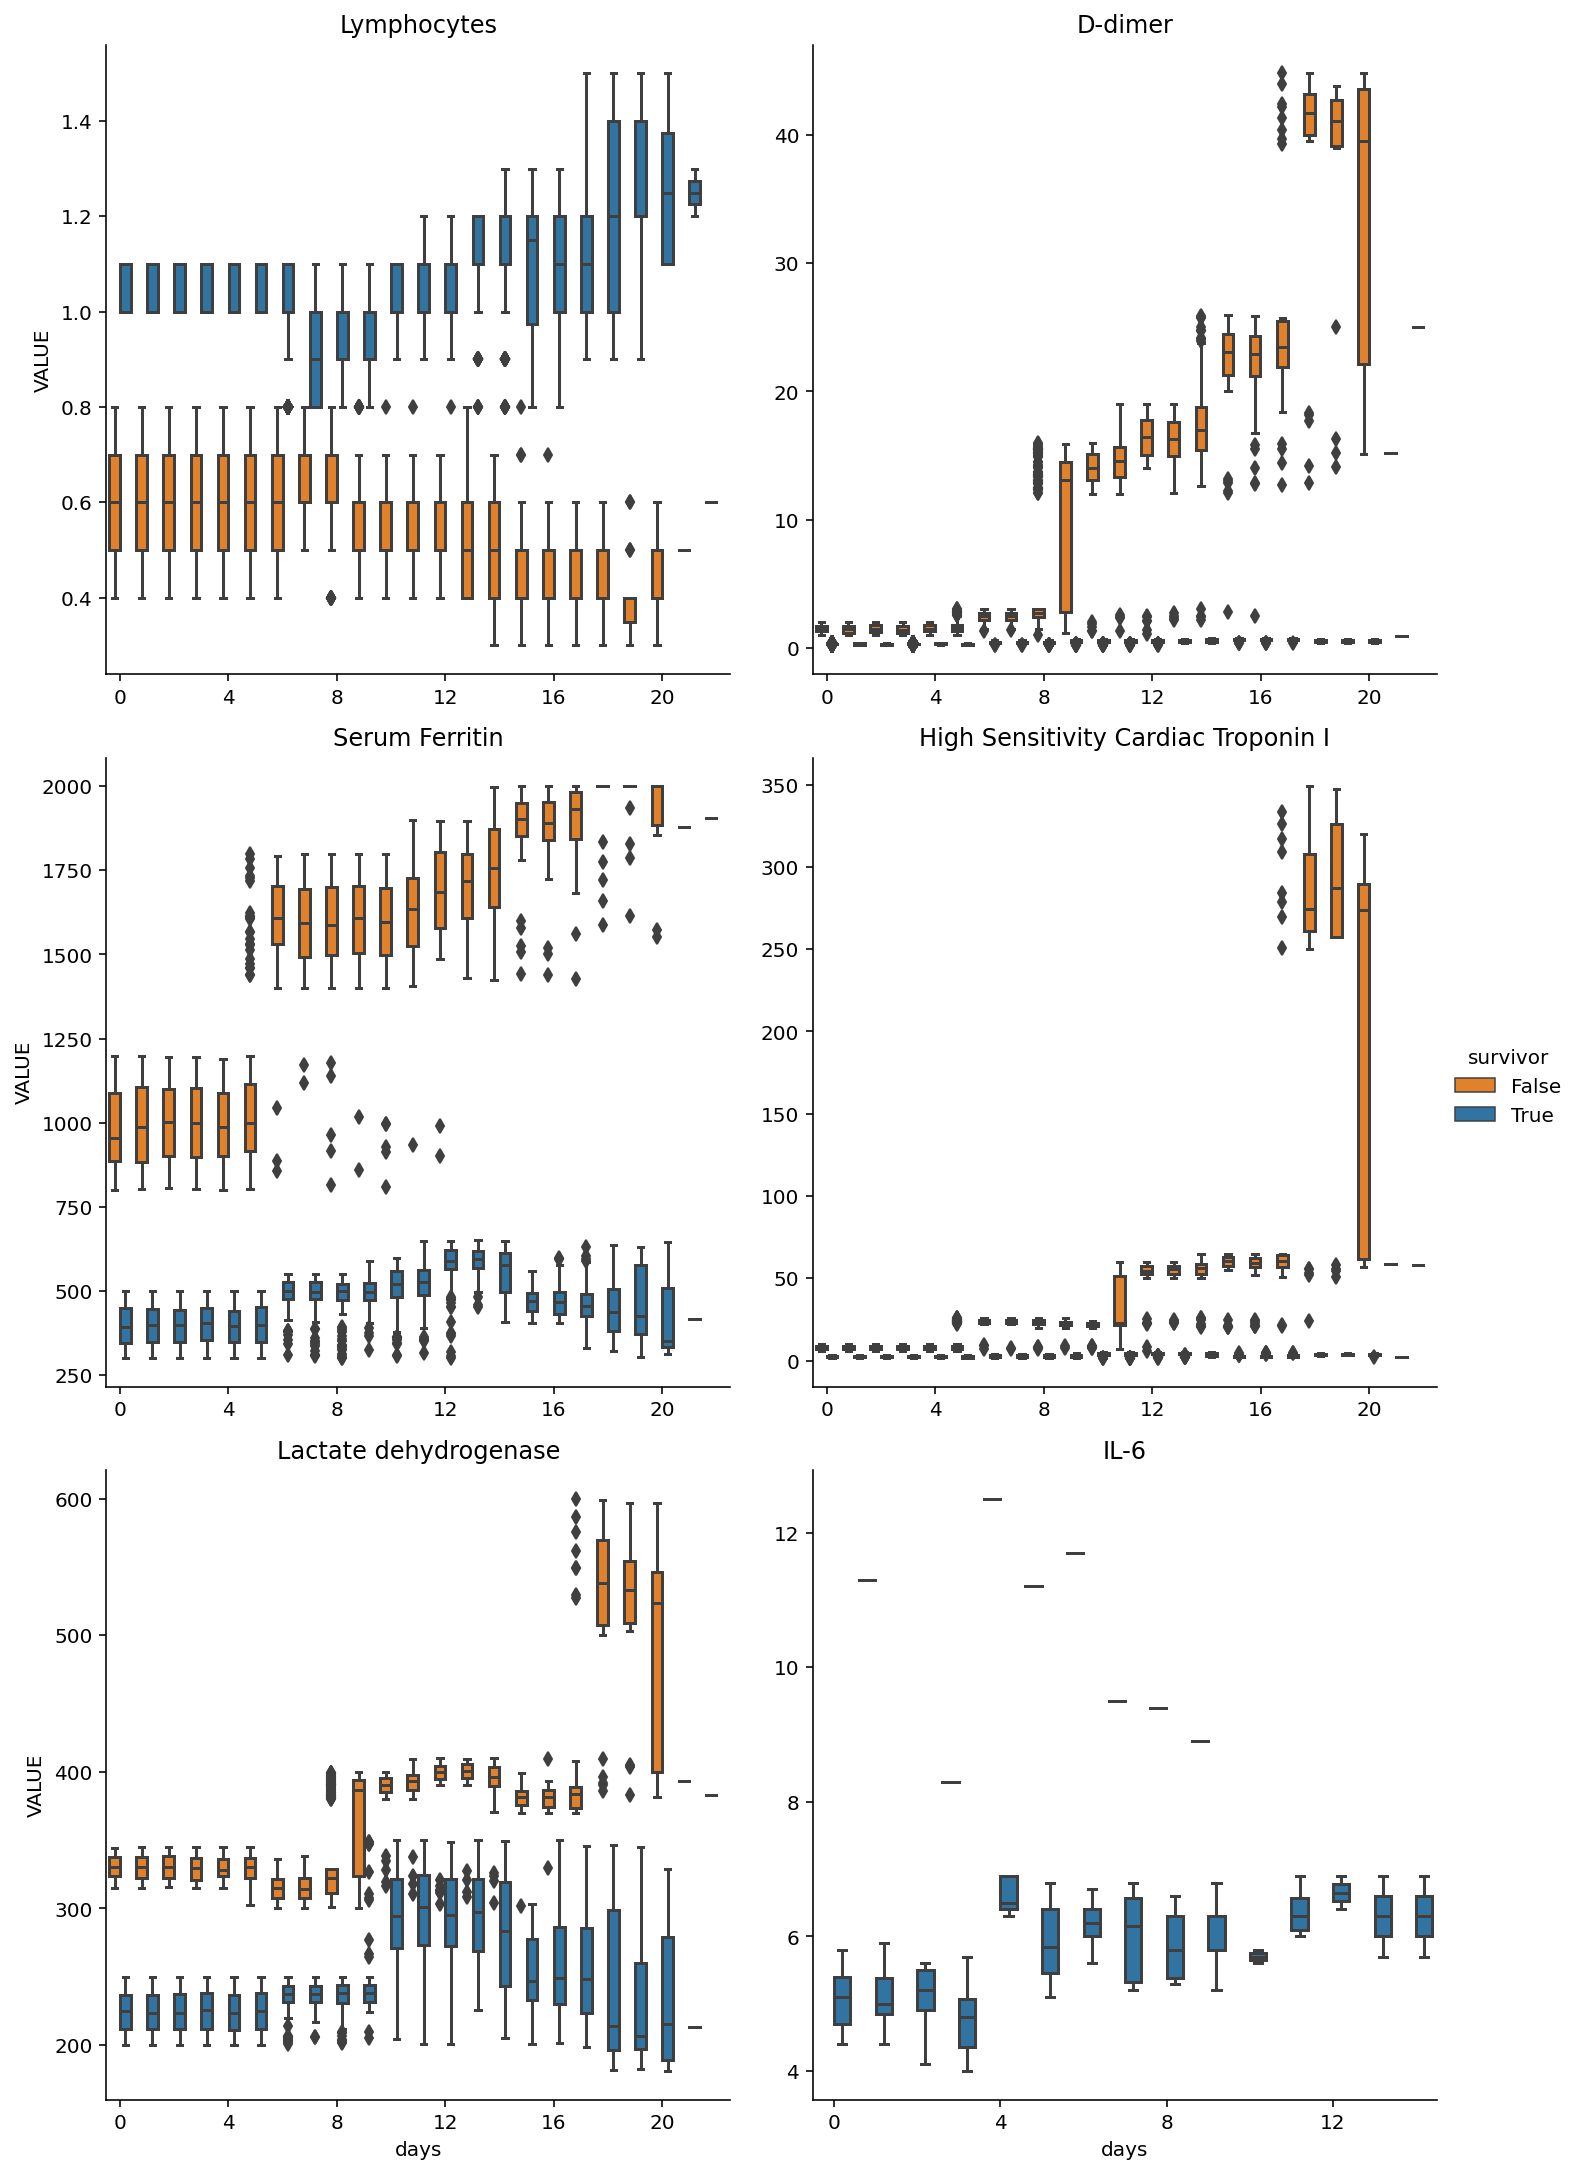

In [24]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="box", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])
        
plt.show()

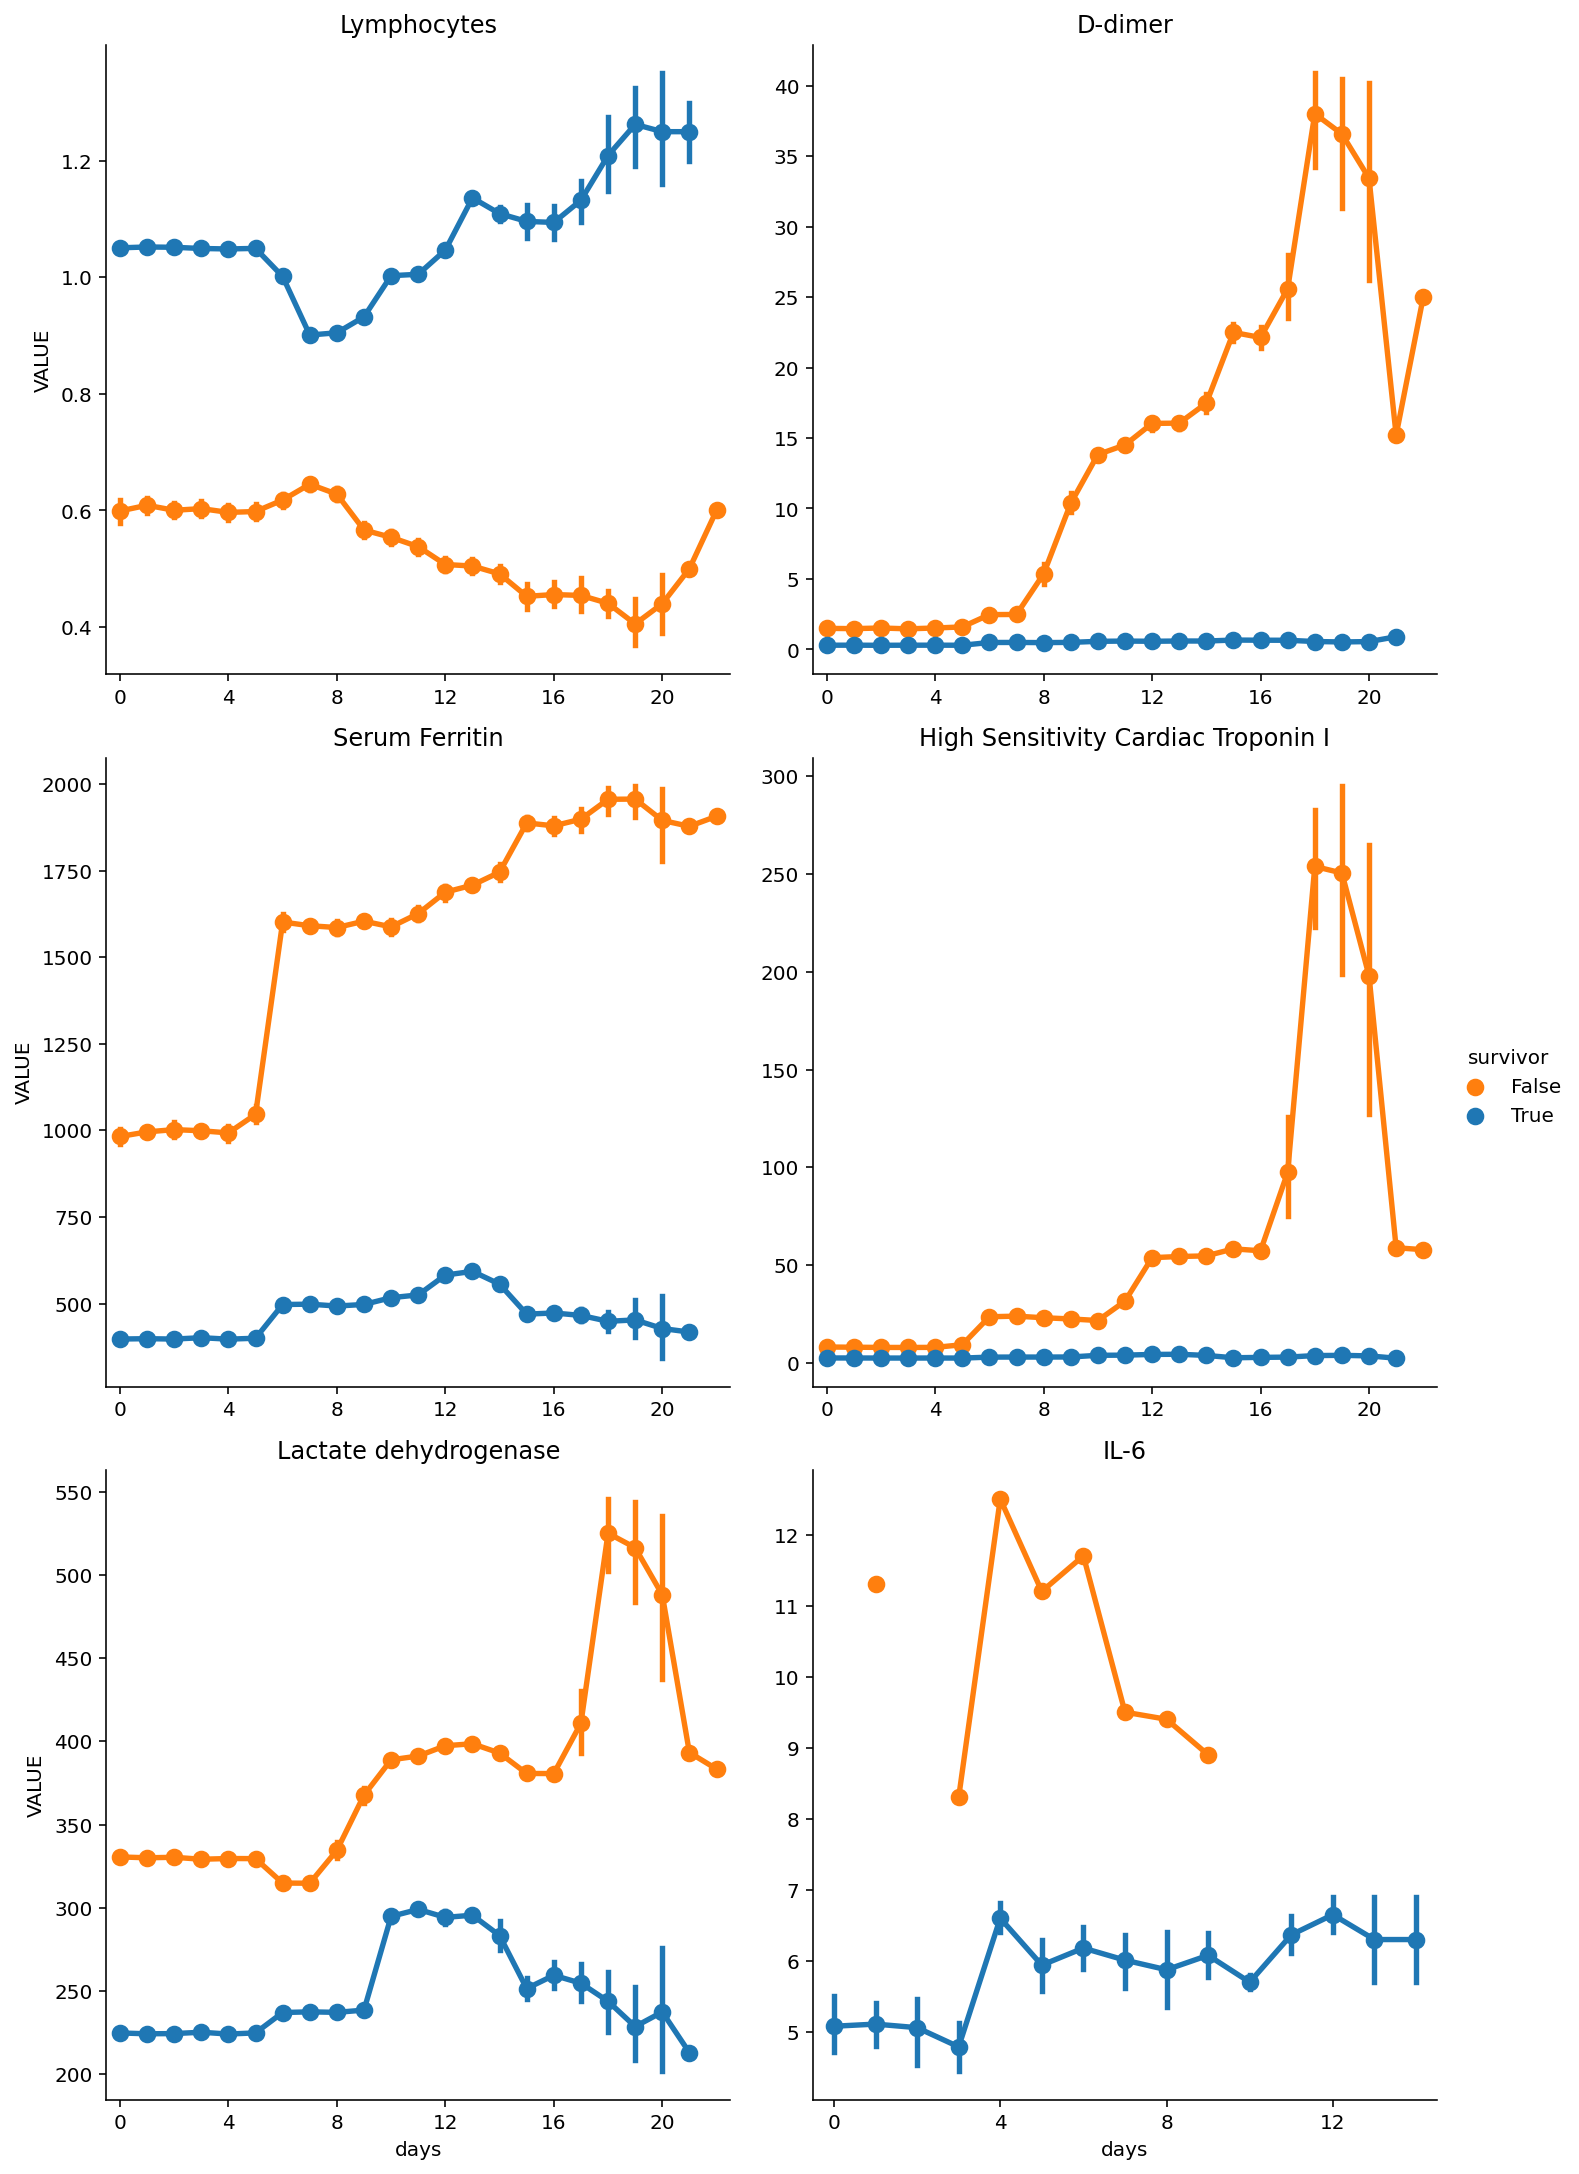

In [25]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="point", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])

plt.show()

Set up a new DataFrame with boolean columns representing various outcomes, like admit, recovery or death

In [26]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

## Outcomes for all COVID-19 Patients

This code builds a new DataFrame for the purposes of display. The DataFrame contains the percentages of patients that experience a particular outcome. Percentages are then provided for only hospitalized patients, ICU admitted patients and ventilated patients.

In [27]:
hospitalized = (cp.admit == True)
icu = (cp.icu_admit == True)
vent = (cp.ventilated == True)
covid_count = cp.Id.size
row_filters = {'Home Isolation': (cp.isolation == True), 'Hospital Admission': hospitalized, 'ICU Admission': icu,
 'Ventilated': vent, 'Recovered': (cp.recovered == True), 'Death': (cp.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['All Patients'] = cp[row_filter].Id.size / covid_count
    row['Hospitalized'] = cp[row_filter & hospitalized].Id.size / hospitalized.value_counts()[True]
    row['ICU Admitted'] = cp[row_filter & icu].Id.size / icu.value_counts()[True]
    row['Required Ventilation'] = cp[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,All Patients,Hospitalized,ICU Admitted,Required Ventilation
0,Home Isolation,0.802747,0.027420,0.021680,0.023649
1,Hospital Admission,0.202815,1.000000,1.000000,1.000000
2,ICU Admission,0.041879,0.206491,1.000000,1.000000
3,Ventilated,0.033594,0.165641,0.802168,1.000000
4,Recovered,0.958915,0.800783,0.300813,0.128378
5,Death,0.042333,0.202015,0.699187,0.871622


## Outcomes for ICU Admitted Patients

Essentially a sub table from above, looking only at ICU patients.

In [28]:
icu_only = cp[cp.icu_admit == True]

vent = (icu_only.ventilated == True)
covid_count = icu_only.Id.size
row_filters = {'Ventilated': vent, 'Recovered': (icu_only.recovered == True), 'Death': (icu_only.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['ICU Admitted'] = icu_only[row_filter].Id.size / covid_count
    row['Required Ventilation'] = icu_only[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,ICU Admitted,Required Ventilation
0,Ventilated,0.802168,1.000000
1,Recovered,0.300813,0.128378
2,Death,0.699187,0.871622


Start to build a DataFrame that we can use to look at other conditions in relation to COVID-19

In [29]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]

In [30]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

Grab all of the conditions starting after January 20, 2020. This is a hack to get only conditions that are related to COVID-19. We will end up merging these with the COVID patients.

In [31]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

This DataFrame will contain all conditions for COVID-19 patients, where `START` can be compared to `covid_start` to see how long after the COVID-19 diagnosis something happened.

In [32]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

## Symptoms for all COVID-19 Patients

Generates a DataFrame with percentages of co-occurring conditions

In [33]:
analysis.symptom_table(covid_patient_conditions)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,0.008854,78,0.008641,73,0.013405,5
1,Nasal Congestion,0.049830,439,0.050545,427,0.032172,12
2,Headache,0.142111,1252,0.140743,1189,0.168901,63
3,Cough,0.688195,6063,0.686435,5799,0.734584,274
4,Sore Throat,0.139614,1230,0.139086,1175,0.158177,59
5,Sputum Production,0.332463,2929,0.333215,2815,0.316354,118
6,Fatigue,0.388990,3427,0.390507,3299,0.359249,134
7,Hemoptysis,0.011464,101,0.010772,91,0.026810,10
8,Shortness of Breath,0.198638,1750,0.190933,1613,0.369973,138
9,Nausea,0.055959,493,0.055161,466,0.072386,27


## Symptoms for ICU admitted COVID-19 Patients

DataFrame limited to individuals admitted to the ICU

In [34]:
analysis.symptom_table(covid_patient_conditions, True)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,0.024390,9,0.036036,4,0.019380,5
1,Nasal Congestion,0.040650,15,0.063063,7,0.031008,8
2,Headache,0.170732,63,0.153153,17,0.178295,46
3,Cough,0.699187,258,0.711712,79,0.693798,179
4,Sore Throat,0.154472,57,0.171171,19,0.147287,38
5,Sputum Production,0.327913,121,0.342342,38,0.321705,83
6,Fatigue,0.384824,142,0.405405,45,0.375969,97
7,Hemoptysis,0.021680,8,0.027027,3,0.019380,5
8,Shortness of Breath,0.384824,142,0.387387,43,0.383721,99
9,Nausea,0.075881,28,0.099099,11,0.065891,17


Create a DataFrame with columns that show a condition's start and end in days relative to COVID-19 diagnosis. Also create a column that calculates the number of days between COVID-19 diagnosis and a person's death.

In [35]:
covid_patient_conditions['start_days'] = (pd.to_datetime(covid_patient_conditions.START) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['end_days'] = (pd.to_datetime(covid_patient_conditions.STOP) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['death_days'] = (pd.to_datetime(covid_patient_conditions.DEATHDATE) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')

## Timelines for hospitalized patients

These plots show the progression of COVID-19 related complications in hospitalized patients. The bars represent the average start and end time for the particular item. Arrows at the bottom show the time or start time of a particular item.

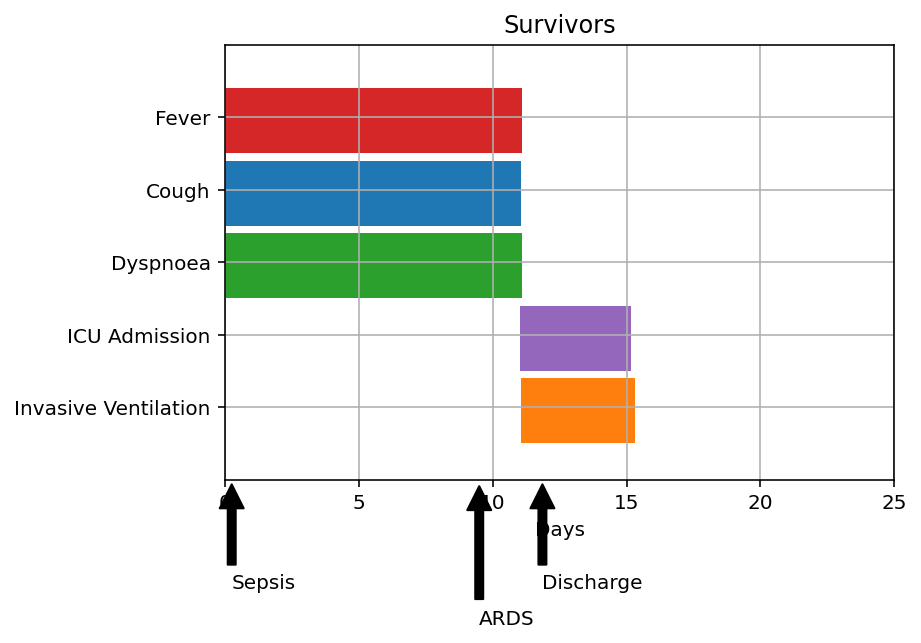

In [36]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

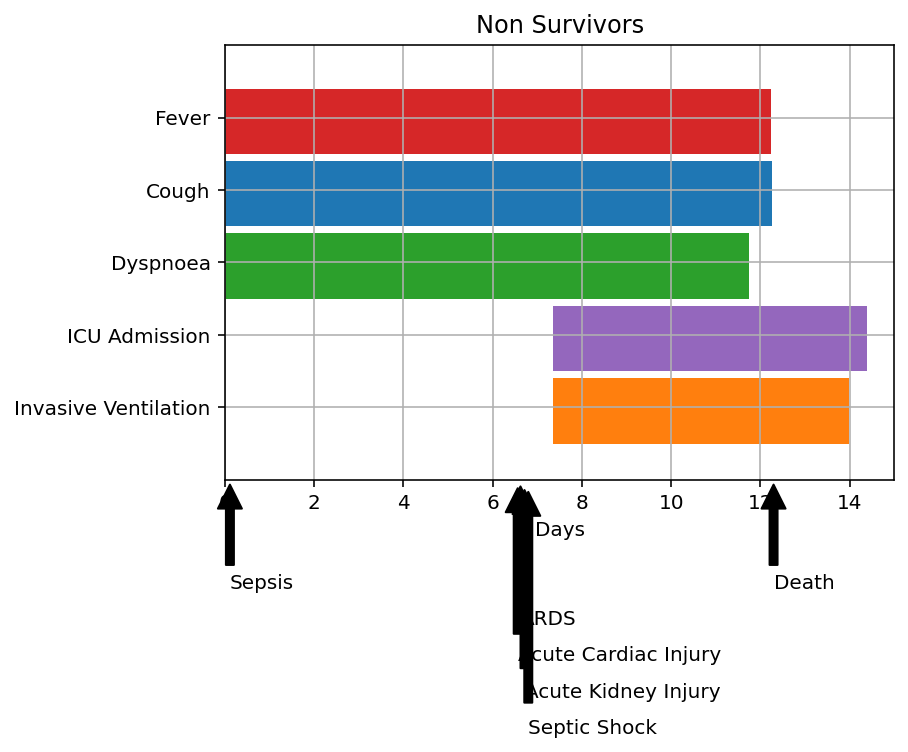

In [37]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

## Timelines for ICU only patients

These plots refine the timelines to only patients with ICU admissions

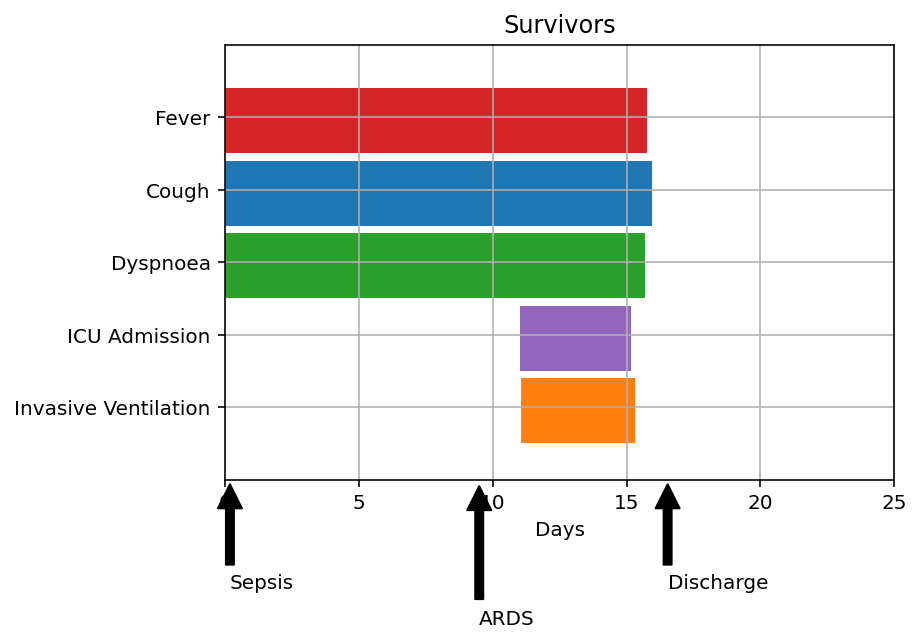

In [38]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info, True)

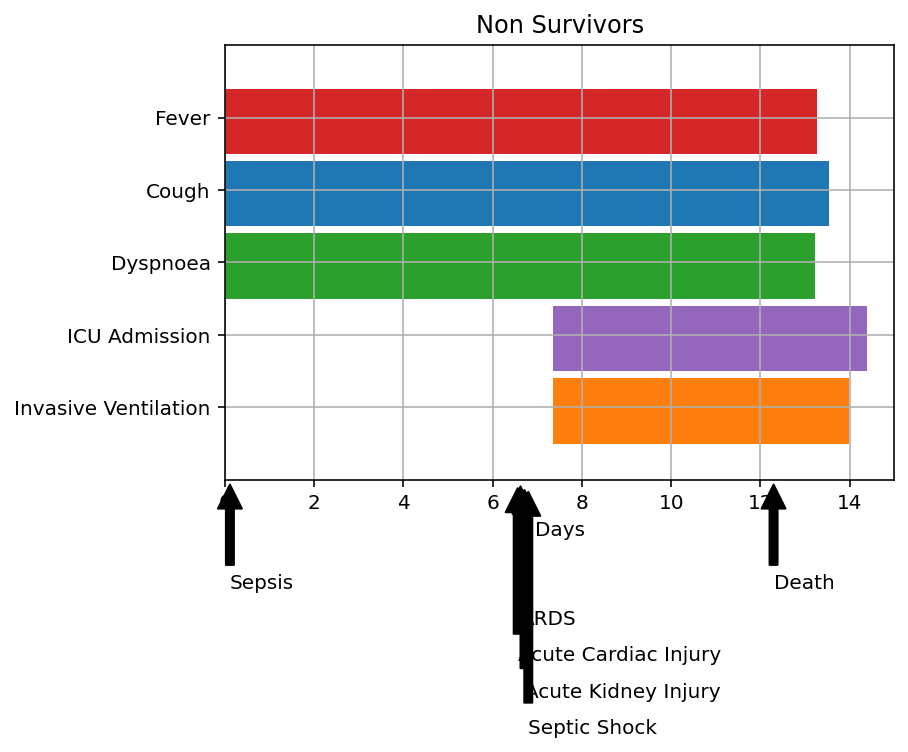

In [39]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

Add an age column to the DataFrame for rows where the patient has died

In [40]:
covid_info.loc[covid_info.death == True, 'age'] = (pd.to_datetime(covid_info.DEATHDATE) - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Populate ages for survivors based on the current date

In [41]:
covid_info.loc[covid_info.recovered == True, 'age'] = (datetime.datetime.now() - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Create an age_range column that places individuals into 10 year age ranges, such as 0 - 10, 10 - 20, etc.

In [42]:
bins = list(range(0, 120, 10))
covid_info['age_range'] = pd.cut(covid_info.age, bins=bins)

## Mortality by Age and Sex

A plot of deaths grouped by age range and gender.

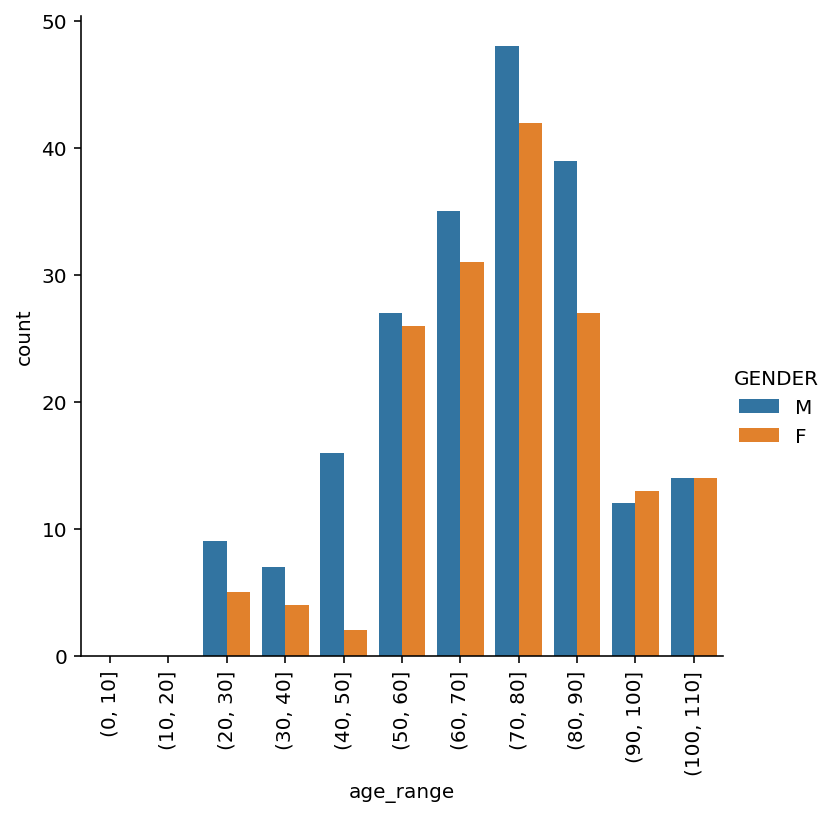

In [43]:
chart = sns.catplot(x="age_range", kind="count", hue="GENDER", data=covid_info[covid_info.death==True]);
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

A table view of the same information from above

In [44]:
covid_info[covid_info.death==True].groupby(['age_range', 'GENDER']).count()[['PATIENT']]

PATIENT
age_range  GENDER         
(0, 10]    F             0
           M             0
(10, 20]   F             0
           M             0
(20, 30]   F             5
           M             9
(30, 40]   F             4
           M             7
(40, 50]   F             2
           M            16
(50, 60]   F            26
           M            27
(60, 70]   F            31
           M            35
(70, 80]   F            42
           M            48
(80, 90]   F            27
           M            39
(90, 100]  F            13
           M            12
(100, 110] F            14
           M            14

Another table view of the mortality data, this time just grouped by age range

In [45]:
covid_info[covid_info.death==True].groupby(['age_range']).count()[['PATIENT']]

,PATIENT
age_range,
"(0, 10]",0
"(10, 20]",0
"(20, 30]",14
"(30, 40]",11
"(40, 50]",18
"(50, 60]",53
"(60, 70]",66
"(70, 80]",90
"(80, 90]",66


Build a DataFrame that shows the total count of a supply used on a given day

In [46]:
grouped_supplies = supplies.groupby(['DESCRIPTION', 'DATE']).sum()

## Supply Usage

Small multiples plot of supply usage over time.

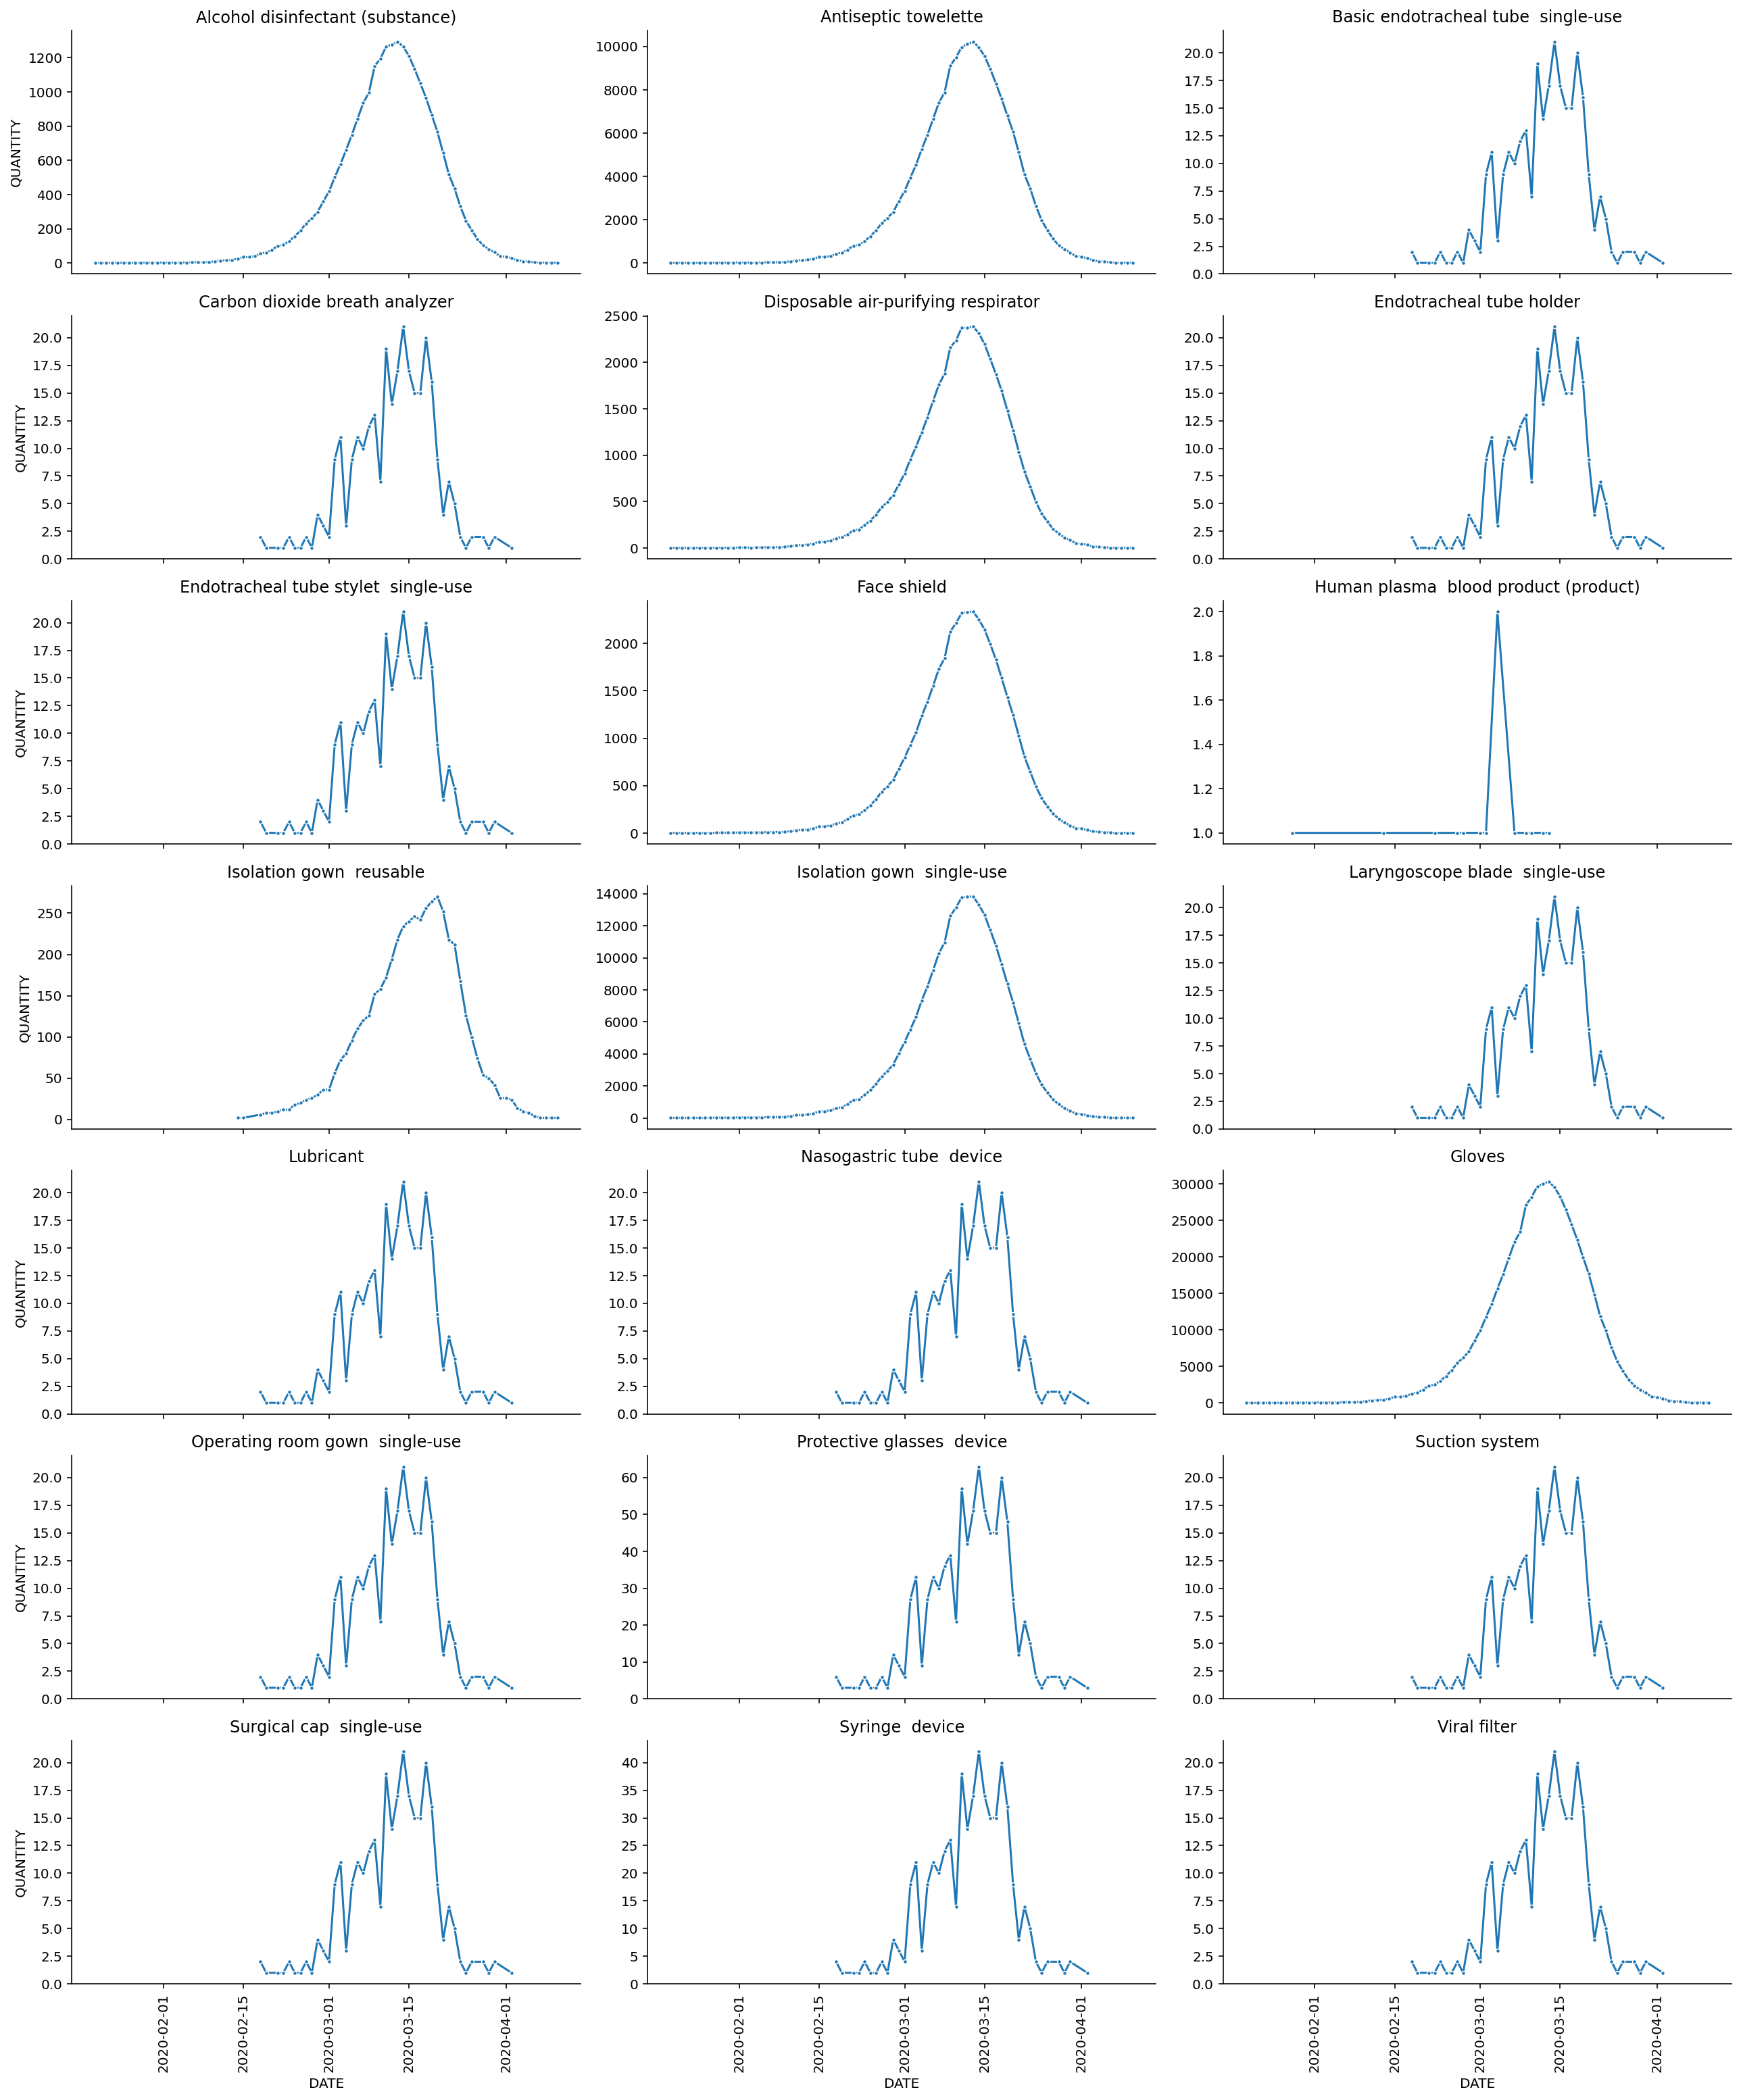

In [47]:
gs = grouped_supplies.reset_index()
gs['DATE'] = pd.to_datetime(gs.DATE)
g = sns.FacetGrid(gs, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "DATE", "QUANTITY", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    if 'glove' in title:
        axes.set_title('Gloves')
    else:    
        axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

A table showing total supplies used over the entire simulation

In [48]:
supplies.groupby(['DESCRIPTION']).sum()[['QUANTITY']]

,QUANTITY
DESCRIPTION,
Alcohol disinfectant (substance),24292
Antiseptic towelette (physical object),192264
Basic endotracheal tube single-use (physical object),296
Carbon dioxide breath analyzer (physical object),296
Disposable air-purifying respirator (physical object),43908
Endotracheal tube holder (physical object),296
Endotracheal tube stylet single-use (physical object),296
Face shield (physical object),43020
Human plasma blood product (product),14


Build a DataFrame that has cumulative case counts over time

In [49]:
case_counts = conditions[conditions.CODE == 840539006].groupby('START').count()[['PATIENT']]
case_counts['total'] = case_counts['PATIENT'].cumsum()
case_counts = case_counts.rename(columns={'PATIENT': 'daily'})
case_counts = case_counts.reset_index()
case_counts['START'] = pd.to_datetime(case_counts.START)

## Cumulative Case Count

Show total cases over time

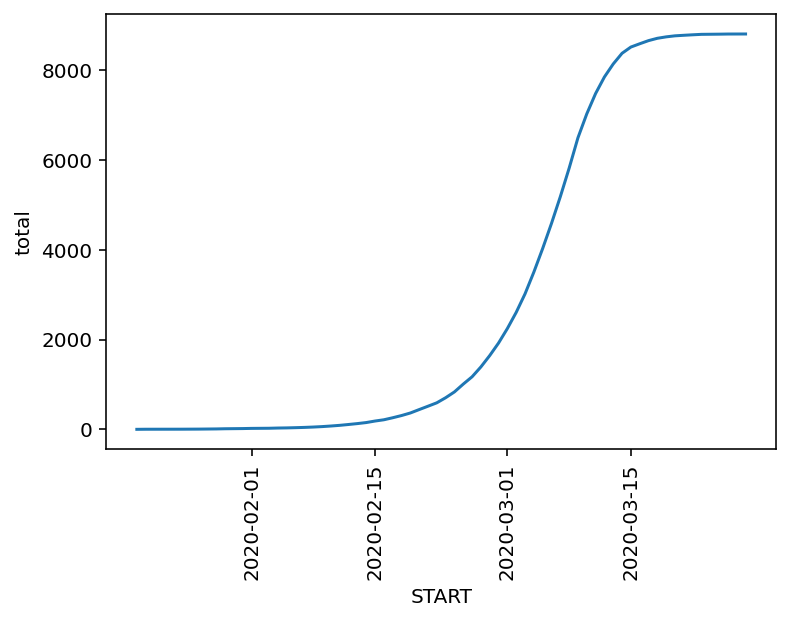

In [50]:
axes = sns.lineplot(x='START', y='total', data=case_counts)
plt.xticks(rotation=90)
plt.show()

## Medication Dispenses

This table shows medications dispensed to patients with COVID-19 since January 20, 2020.

In [51]:
covid_meds = medications[pd.to_datetime(medications.START) > pd.to_datetime('2020-01-20', utc=True)]
covid_meds = covid_info.merge(covid_meds, on='PATIENT')

In [52]:
covid_meds.groupby(['DESCRIPTION']).sum()[['DISPENSES']].sort_values('DISPENSES', ascending=False).head(10)

,DISPENSES
DESCRIPTION,
Acetaminophen 500 MG Oral Tablet,4473
0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe,4402
1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe,2325
NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler,2138
Simvastatin 10 MG Oral Tablet,725
Hydrochlorothiazide 25 MG Oral Tablet,709
amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet,645
insulin human isophane 70 UNT/ML / Regular Insulin Human 30 UNT/ML Injectable Suspension [Humulin],608
Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,542


## Hospital Day Stats

For patients with COVID-19, calculate the average hospital length of stay as well as total hospital days for all COVID-19 patients. Provide the same information for ICU patients

In [53]:
covid_hosp = analysis.create_covid_hosp(covid_info, encounters, {'admit': True}).reset_index()
covid_icu = analysis.create_covid_icu(covid_info, encounters)
pd.DataFrame.from_records([
    {
        'type': 'inpatient',
        'patients': covid_hosp.PATIENT.nunique(),
        'average stay': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).mean(),
        'total days': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).sum(),
    },
    {
        'type': 'ICU',
        'patients': covid_icu.PATIENT.nunique(),
        'average stay': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).mean(),
        'total days': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).sum(),
    }
])

,type,patients,average stay,total days
0,inpatient,1787,11.119277,19870.147917
1,ICU,369,6.155448,2271.360417


In [54]:
device_codes = [448907002, 449071006, 36965003]
grouped_dev = devices[devices.CODE.isin(device_codes)].copy()
grouped_dev['START'] = pd.to_datetime(grouped_dev.START).dt.date
grouped_dev = grouped_dev.groupby(['DESCRIPTION', 'START']).count()
grouped_dev = grouped_dev.reset_index()

## Device Usage

Show the number of devices used to treat COVID-19 over time.

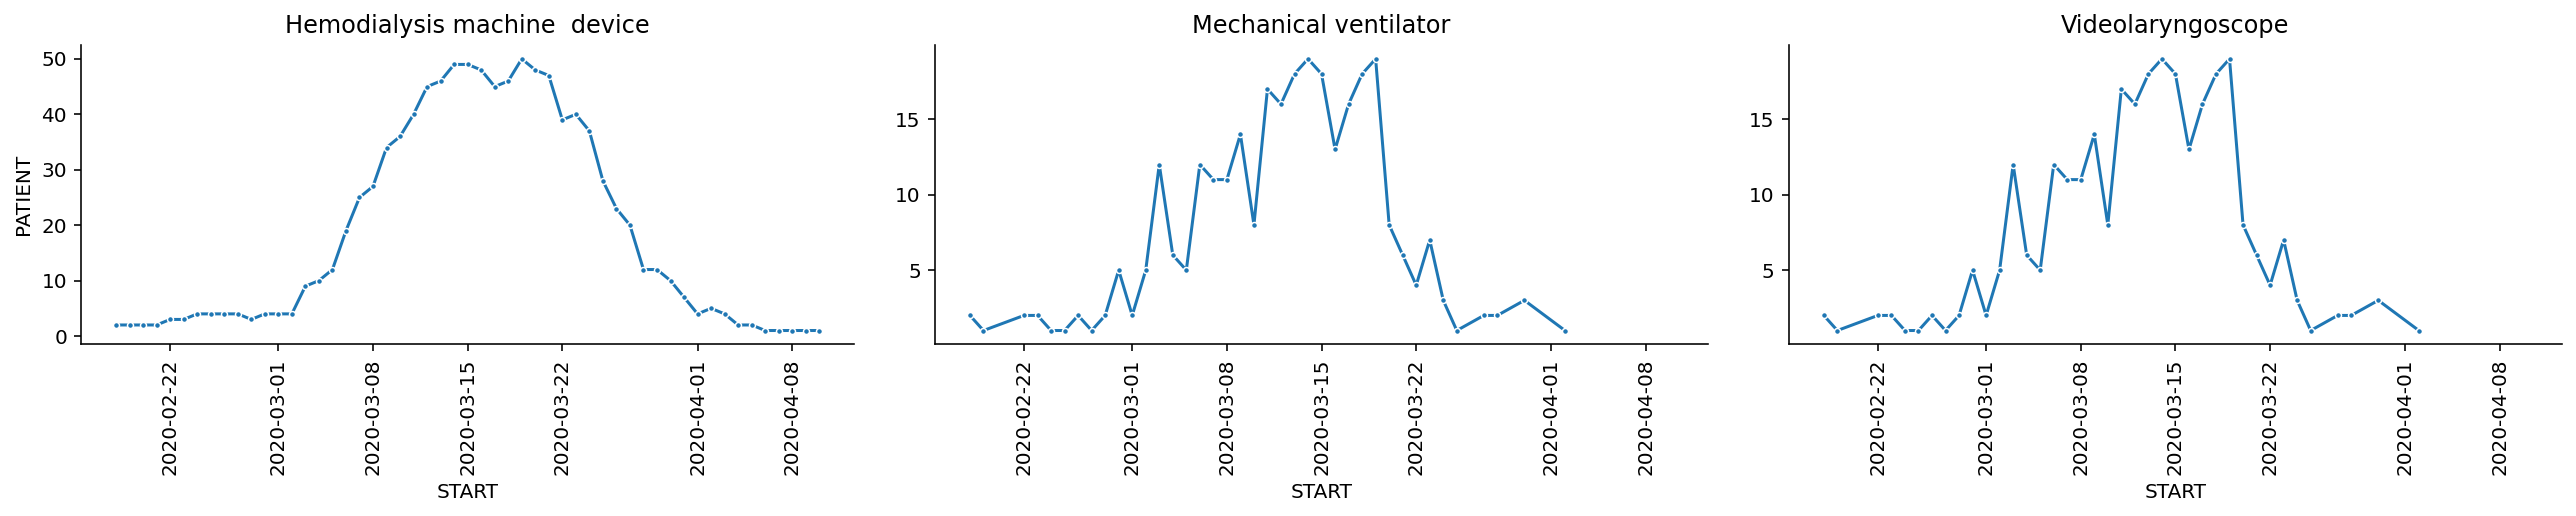

In [55]:
g = sns.FacetGrid(grouped_dev, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "START", "PATIENT", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)